In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

from session.sessions import selected_009266, selected_009265
from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
from target import build_tgt_matrix
import pandas as pd
from aeps import AEP_metrics_lims, outlier_lims

%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions[:2]

['009266_hippoSIT_2023-04-17_17-04-17', '009266_hippoSIT_2023-04-18_10-10-37']

In [9]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
area = 'A1'
metrics = ['P1', 'N1', 'P3']
session = sessions[0]

animal     = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')
aeps_file = os.path.join(dst_path, animal, session, 'AEPs.h5')
aeps_c_file = os.path.join(dst_path, animal, session, 'analysis', 'AEP_components.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    trials       = np.array(f['processed']['trial_idxs'])
    tl           = np.array(f['processed']['timeline'])
    
AEP_metrics_raw  = {}
AEP_metrics_norm = {}
with h5py.File(aeps_c_file, 'r') as f:
    for ds_name in f[area]:
        if ds_name.find('raw') > 0:
            AEP_metrics_raw[ds_name[:2]] = np.array(f[area][ds_name])
        else:
            AEP_metrics_norm[ds_name[:2]] = np.array(f[area][ds_name])
aeps = {}
with h5py.File(aeps_file, 'r') as f:
    for area in f:
        ds_name = [x for x in f[area]][0]
        aeps[area] = np.array(f[area][ds_name])
        
# remove outliers
for area, aeps_mx in aeps.items():
    aeps_no_out = aeps_mx.copy()
    aeps_mx[aeps_mx > outlier_lims[area]]  = outlier_lims[area]
    aeps_mx[aeps_mx < -outlier_lims[area]] = -outlier_lims[area]
    aeps[area] = aeps_no_out

session

'009266_hippoSIT_2023-04-17_17-04-17'

## Build AEP matrix and compute t-SNE/UMAP

In [10]:
# build AEP dynamics matrix
aep_mx = np.column_stack([AEP_metrics_norm[x] for x in metrics])
aep_mx.shape

(9599, 3)

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30) #, random_state=0)
tsne_fit = tsne.fit_transform(aep_mx)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [12]:
from umap import UMAP

umap_2d = UMAP(n_components=2, n_neighbors=30, min_dist=0.1) #, random_state=0, init='random')
umap_fit = umap_2d.fit_transform(aep_mx)

## Events on UMAP

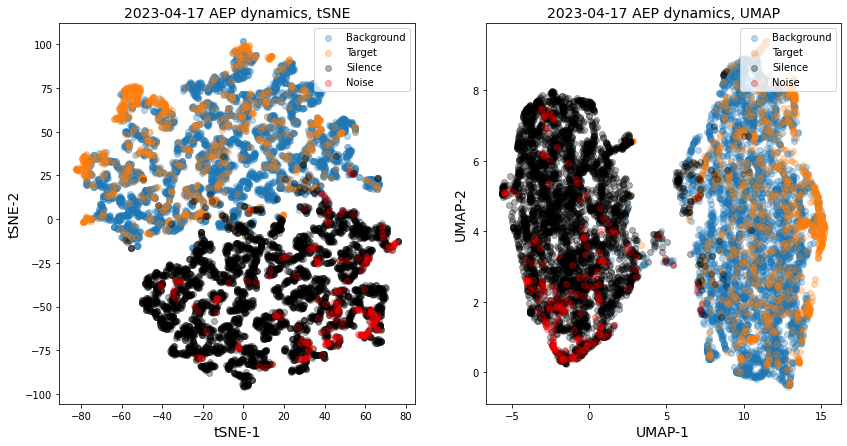

In [13]:
idxs_bgr = np.where(sound_events[:, 1] == 1)[0]
idxs_tgt = np.where(sound_events[:, 1] == 2)[0]
idxs_sil = np.where(sound_events[:, 1] == 0)[0]
idxs_noi = np.where(sound_events[:, 1] == -1)[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

labels = ['Background', 'Target', 'Silence', 'Noise']
colors = ['tab:blue', 'tab:orange', 'black', 'red']
algs   = ['tSNE', 'UMAP']
fits   = [tsne_fit, umap_fit]
for i, idxs in enumerate([idxs_bgr, idxs_tgt, idxs_sil, idxs_noi]):
    for j, ax in enumerate(axes):
        ax.scatter(fits[j][idxs][:, 0], fits[j][idxs][:, 1], alpha=0.3, color=colors[i], label=labels[i])
        ax.set_xlabel('%s-1' % algs[j], fontsize=14)
        ax.set_ylabel('%s-2' % algs[j], fontsize=14)
        ax.set_title('%s AEP dynamics, %s' % (session[-19:-9], algs[j]), fontsize=14)
        ax.legend(loc='upper right')
        ax.grid()
        
report_path = os.path.join(dst_path, animal, session, 'analysis')
#fig.savefig(os.path.join(report_path, 'AEPs_tSNE_UMAP.pdf'))

## AEP metrics

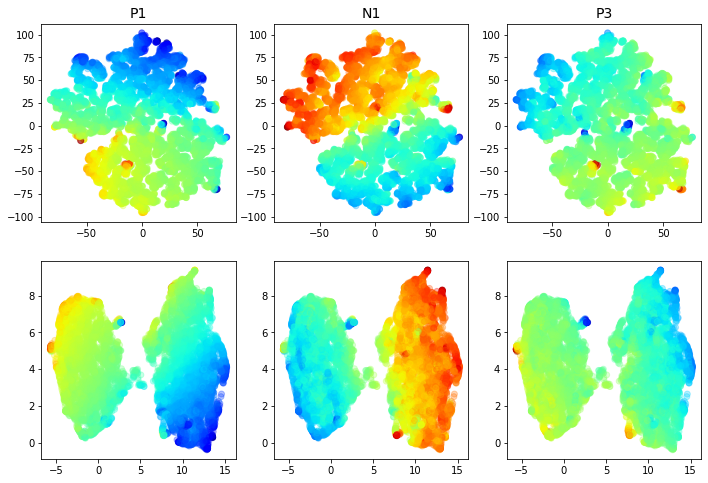

In [14]:
fig = plt.figure(figsize=(16, 8))

for i, m_name in enumerate(metrics):
    # t-SNE
    ax = fig.add_subplot(2, 4, i+1)
    ax.scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=AEP_metrics_norm[m_name], alpha=0.3, cmap='jet')
    ax.set_title(m_name, fontsize=14)
    
    # UMAP
    ax = fig.add_subplot(2, 4, i+5)
    ax.scatter(umap_fit[:, 0], umap_fit[:, 1], c=AEP_metrics_norm[m_name], alpha=0.3, cmap='jet')

In [10]:
def build_bgr_matrix(sound_events, trials):
    # compute timeline / sound indices of bgr sounds
    bgr_start_idxs = [0]
    bgr_end_idxs = []
    
    for i, event in enumerate(sound_events[:-1]):
        if sound_events[i][1] != 1 and sound_events[i+1][1] == 1:
            bgr_start_idxs.append(i+1)
        if sound_events[i][1] == 1 and sound_events[i+1][1] != 1:
            bgr_end_idxs.append(i)
            
    # ignore first/last target if not ended
    #if bgr_start_idxs[-1] > bgr_end_idxs[-1]:
    #    bgr_start_idxs = bgr_start_idxs[:-1]
    #if bgr_end_idxs[0] < bgr_start_idxs[0]:
    #    bgr_end_idxs = bgr_end_idxs[1:]
    bgr_start_idxs = np.array(bgr_start_idxs)
    bgr_end_idxs   = np.array(bgr_end_idxs)
    
    print(bgr_start_idxs.shape, bgr_end_idxs.shape)
    
    # tl_idx_start, tl_idx_end, aep_idx_start, aer_idx_end
    return np.column_stack([
        bgr_start_idxs,
        bgr_end_idxs,
        sound_events[bgr_start_idxs][:, 2],
        sound_events[bgr_end_idxs][:, 2],
    ]).astype(np.int32)

(74,) (74,)


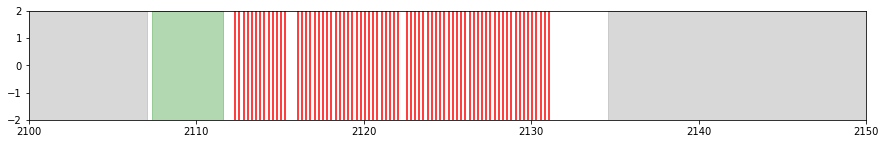

In [11]:
t_start, t_end = 2100, 2150  # secs
bgr_mx = build_bgr_matrix(sound_events, trials)
hall_idxs = np.where((umap_fit[:, 0] < 5) & (sound_events[:, 1] == 0))[0]

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

#for i, metric in enumerate(AEP_metrics_raw.keys()):
ax.vlines(sound_events[hall_idxs][:, 0], ymin=-2, ymax=2, color='red')
#axes[i].set_ylabel(metric, fontsize=14)
for tgt_event in tgt_mx:
    ax.axvspan(tl[tgt_event[2]][0], tl[tgt_event[3]][0], alpha=0.3, color='green')
ax.set_xlim(t_start, t_end)
ax.set_ylim(-2, 2)
for bgr_event in bgr_mx:
    ax.axvspan(tl[bgr_event[2]][0], tl[bgr_event[3]][0], alpha=0.3, color='gray')
#axes[3].set_xlabel('Time, s', fontsize=14)
#axes[1].axvline(1235, color='red')

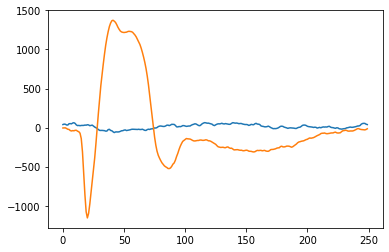

In [12]:
area = 'A1'
plt.plot(aeps[area][hall_idxs].mean(axis=0))
plt.plot(aeps[area][sound_events[:, 1] == 1].mean(axis=0))